In [2]:
%cd /home/kenji/Projects/BasicProjects/KMeans_Numbers

/home/kenji/Projects/BasicProjects/KMeans_Numbers


In [3]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import scale, LabelEncoder, OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [160]:
## 1. Data

### 1.1 Load Data

# source: https://archive-beta.ics.uci.edu/ml/datasets/clickstream+data+for+online+shopping


import pickle
import glob
tsv_files = glob.glob("Data/tsv/*.tsv")
database = {}
for file in tsv_files:
    data = pd.read_table(file,low_memory=False,na_values=['\\N','nan'])
    #TODO use regex or something to clean up file name/key.
    database[file] = data
    print(f'{file} has been added to our database.')
    
#keep for now, might be needed for deploymentfor possibly pickling for later storage.
#

KeyboardInterrupt: 

In [ ]:
### 1.1 Inspeact Data

# print(data.describe(),'\n')
def get_multi_info(database):
    for name,data in database.items():
        print(name)
        print(data.info(memory_usage='deep'),'\n')

get_multi_info(database)

In [ ]:
# At this point, the memory required by the data is way too high with some tables taking between 3 and 13 gigabytes of memory.
# To start, for each table I'm going to select only the columns I'm interested in and then filter down to only the data I'm interested before merging all tables into a single DataFrame.

In [ ]:
# columns I'm keeping for each table.
keep_basics = ['tconst','titleType','primaryTitle','startYear','runtimeMinutes','genres']
keep_principals = ['tconst','ordering','nconst','category','job','characters']
keep_ratings = ['tconst','averageRating','numVotes']
keep_crew = ['tconst','directors','writers']
keep_name = ['nconst','primaryName','birthYear','primaryProfession','knownForTitles']

In [ ]:
#TODO Get rid of all of this, just make the date_ off the bat. Expensive trial and error is done.
data_basics = database['Data/tsv/basics.tsv'][keep_basics]
data_principals = database['Data/tsv/principals.tsv'][keep_principals]
data_ratings = database['Data/tsv/ratings.tsv'][keep_ratings]
data_crew = database['Data/tsv/crew.tsv'][keep_crew]
data_name = database['Data/tsv/name.tsv'][keep_name]

In [ ]:
# Let's check out the first table
data_basics.head()

In [ ]:
#### 1.2.2 Examine & Modify Dataset Columns
print(f'Original Column Names: {data_basics.columns}')
# getting rid of camel casing
data_basics.columns = map(str.lower, data_basics.columns)
print(f'Lowercased Column Names: {data_basics.columns}')

In [ ]:
'''data dictionary
tconst  =   title id of the movie
primarytitle    =   primary title the movie goes by
startyear   =   year realease
runtimeminutes  =   film duration
genres  =   list of each genre the film represents
ordering    =   order of precedence if co-directors/writers/producers
nconst  =   name id or director, writer
category    =   job category
primaryname =   director/writer name gone by
primaryprofession   =   primary postion of principal
knownfortitles  =   previous works by principle
averagerating   =   films average rating
numvotes    =   number of votes film has received
directors   =   list of directors
writers =   list of writers'''

In [ ]:
# Repeating for all tables
data_principals.columns = map(str.lower, data_principals.columns)
data_ratings.columns = map(str.lower, data_ratings.columns)
data_crew.columns = map(str.lower, data_crew.columns)
data_name.columns = map(str.lower, data_name.columns)

In [ ]:
# I want classic horror for this project.
data_basics = data_basics[data_basics.startyear.between(1900, 1949)]
# collecting all the different genres and their combinations.
genres = data_basics.genres.unique().tolist()
# creating a set of all genre values that include horror.
horrors = [genre for genre in genres if str(genre).find('Horror') !=-1 ]
# filtering the data to only observations that have horror in their genre.
data_basics = data_basics.loc[data_basics['genres'].isin(horrors)]
# only interested in films.
data_basics = data_basics[data_basics.titletype == 'movie']
# don't need this.
data_basics.drop('titletype', axis=1,inplace=True)
# removing observations that don't have a runtime.
data_basics.dropna(subset=['runtimeminutes'],inplace=True)
# don't need
data_principals.drop(['job','characters'], axis=1,inplace=True)

In [ ]:
# combining tables
data = data_basics.merge(data_principals, how='left',on='tconst')
data = data.merge(data_name, how='left',on='nconst')
data = data.merge(data_ratings, how='left',on='tconst')
data = data.merge(data_crew, how='left',on='tconst')
data.drop('birthyear', axis=1,inplace=True)

In [ ]:
# Missing Values?
def missing_data(data):
    total = 0
    maxi = 0
    for i in data.columns:
        print(f'Checking {i}')
        missing = data[i].isnull().sum()
        if missing > 0:
            total+=missing
            if missing > maxi:
                maxi = missing
            print(f'Missing: {data[i].isnull().sum()}\n')
        else:
            print(f'Nothing Missing in {i}\n')
    if total != 0:
        print(f'Missing {total} out of {len(data)} records, {round(maxi/len(data)*100)}% to {round(total/len(data)*100)}%')
    else:
        print(f'Nothing Missing\n')
missing_data(data)

In [ ]:
def get_multi_cols_counts(data):
    for i in data:
        print(f"Columns:\n")
        for j in data.columns:
            print(j)
        #print(f'\nChecking {name} Unique Values: \n')
        
        #print(f'\nChecking {i} Unique Values: \n')
        for k in data.columns:
            if type(k) != int:
                #print(f'\nUnique Values:')
                #print(data[k].unique(),'\n')
                print(f'\nValue Counts for {k}:\n')
                print(data[k].value_counts(dropna=False),'\n')

get_multi_cols_counts(data)

In [ ]:
missing_data(data)

In [ ]:
data.dropna(axis=0, how='any', thresh=None, inplace=True)

In [ ]:
missing_data(data)

In [ ]:
data.to_csv(f'Data/data.csv',index=False)

In [45]:
data = pd.read_csv(f'Data/data.csv')

In [46]:
### 1.2 Inspeact Data (again)
data.head()

,tconst,primarytitle,startyear,runtimeminutes,genres,ordering,nconst,category,primaryname,primaryprofession,knownfortitles,averagerating,numvotes,directors,writers
0,tt0003419,The Student of Prague,1913.0,85,"Drama,Fantasy,Horror",10,nm0226278,production_designer,Robert A. Dietrich,"art_director,production_designer,director","tt0133949,tt0006820,tt0444711,tt0489555",6.4,2071.0,"nm0753233,nm0917467","nm0263912,nm0210503"
1,tt0003419,The Student of Prague,1913.0,85,"Drama,Fantasy,Horror",1,nm0917467,actor,Paul Wegener,"actor,director,writer","tt0003419,tt0004026,tt0008431,tt0176776",6.4,2071.0,"nm0753233,nm0917467","nm0263912,nm0210503"
2,tt0003419,The Student of Prague,1913.0,85,"Drama,Fantasy,Horror",2,nm0074186,actress,Grete Berger,actress,"tt0013086,tt0012494,tt0003419,tt0003390",6.4,2071.0,"nm0753233,nm0917467","nm0263912,nm0210503"
3,tt0003419,The Student of Prague,1913.0,85,"Drama,Fantasy,Horror",3,nm0758802,actress,Lyda Salmonova,actress,"tt0003419,tt0004026,tt0014291,tt0002833",6.4,2071.0,"nm0753233,nm0917467","nm0263912,nm0210503"
4,tt0003419,The Student of Prague,1913.0,85,"Drama,Fantasy,Horror",4,nm0332024,actor,John Gottowt,"actor,director,writer","tt0013442,tt0009483,tt0339636,tt0003419",6.4,2071.0,"nm0753233,nm0917467","nm0263912,nm0210503"


In [47]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3273 entries, 0 to 3272
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tconst             3273 non-null   object 
 1   primarytitle       3273 non-null   object 
 2   startyear          3273 non-null   float64
 3   runtimeminutes     3273 non-null   int64  
 4   genres             3273 non-null   object 
 5   ordering           3273 non-null   int64  
 6   nconst             3273 non-null   object 
 7   category           3273 non-null   object 
 8   primaryname        3273 non-null   object 
 9   primaryprofession  3273 non-null   object 
 10  knownfortitles     3273 non-null   object 
 11  averagerating      3273 non-null   float64
 12  numvotes           3273 non-null   float64
 13  directors          3273 non-null   object 
 14  writers            3273 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 2.4 MB


In [48]:
data.shape

(3273, 15)

In [49]:
# Amazing! The data has been reduced to only 2.4MB!

data dictionary

tconst  =   title id of the movie

primarytitle    =   primary title the movie goes by

startyear   =   year realease

runtimeminutes  =   film duration

genres  =   list of each genre the film represents

ordering    =   order of precedence if co-directors/writers/producers

nconst  =   name id or director, writer

category    =   job category

primaryname =   director/writer name gone by

primaryprofession   =   primary postion of principal

knownfortitles  =   previous works by principle

averagerating   =   films average rating

numvotes    =   number of votes film has received

directors   =   list of directors

writers =   list of writers

In [50]:
# check for duplcates.
data[data.duplicated() == True]

,tconst,primarytitle,startyear,runtimeminutes,genres,ordering,nconst,category,primaryname,primaryprofession,knownfortitles,averagerating,numvotes,directors,writers


In [51]:
# check for null values
data[data.isnull().any(axis=1)]

,tconst,primarytitle,startyear,runtimeminutes,genres,ordering,nconst,category,primaryname,primaryprofession,knownfortitles,averagerating,numvotes,directors,writers


In [52]:
# just doublechecking.
data.isna().sum()  

tconst               0
primarytitle         0
startyear            0
runtimeminutes       0
genres               0
ordering             0
nconst               0
category             0
primaryname          0
primaryprofession    0
knownfortitles       0
averagerating        0
numvotes             0
directors            0
writers              0
dtype: int64

In [53]:
# Inspect and Modify columns
data.columns
# The columns are already formatted to lowercase.

Index(['tconst', 'primarytitle', 'startyear', 'runtimeminutes', 'genres',
       'ordering', 'nconst', 'category', 'primaryname', 'primaryprofession',
       'knownfortitles', 'averagerating', 'numvotes', 'directors', 'writers'],
      dtype='object')

In [54]:
# check for number of unique values for each variable.
data.nunique()

tconst                336
primarytitle          321
startyear              37
runtimeminutes         71
genres                 56
ordering               10
nconst               2343
category               10
primaryname          2340
primaryprofession     361
knownfortitles       2314
averagerating          49
numvotes              295
directors             228
writers               322
dtype: int64

In [55]:
data.genres.value_counts()
# Looking at these unique genre values it's apparent that there are several classes represented:
# Pure horror, primarily horror with elements from other genres, and other genres with horrow elements.
#TODO Tighten the scope of genres when coposing the dataframe from raw dat.

Horror                       341
Drama,Horror,Mystery         249
Drama,Horror                 229
Drama,Fantasy,Horror         224
Crime,Drama,Horror           219
Horror,Sci-Fi                159
Horror,Mystery               127
Horror,Mystery,Thriller      120
Drama,Horror,Sci-Fi          109
Crime,Horror,Mystery         109
Comedy,Horror                108
Comedy,Horror,Mystery        107
Horror,Thriller              107
Fantasy,Horror                98
Drama,Horror,Romance          85
Adventure,Horror              50
Horror,Mystery,Sci-Fi         48
Horror,Mystery,Romance        40
Fantasy,Horror,Mystery        40
Drama,Horror,Thriller         40
Fantasy,Horror,Sci-Fi         40
Crime,Horror                  40
Comedy,Drama,Horror           39
Adventure,Drama,Horror        38
Adventure,Horror,Romance      30
Horror,Sci-Fi,Thriller        30
Comedy,Fantasy,Horror         30
Comedy,Crime,Horror           30
Adventure,Crime,Horror        30
Comedy,Horror,Sci-Fi          26
Film-Noir,

In [56]:
data.dtypes

tconst                object
primarytitle          object
startyear            float64
runtimeminutes         int64
genres                object
ordering               int64
nconst                object
category              object
primaryname           object
primaryprofession     object
knownfortitles        object
averagerating        float64
numvotes             float64
directors             object
writers               object
dtype: object

In [57]:
### 1.3 EDA: Initial Summary Stats
data.describe(include='all')

,tconst,primarytitle,startyear,runtimeminutes,genres,ordering,nconst,category,primaryname,primaryprofession,knownfortitles,averagerating,numvotes,directors,writers
count,3273,3273,3273.000000,3273.000000,3273,3273.000000,3273,3273,3273,3273,3273,3273.000000,3273.000000,3273,3273
unique,336,321,NaN,NaN,56,NaN,2343,10,2340,361,2314,NaN,NaN,228,322
top,tt0024055,The Hound of the Baskervilles,NaN,NaN,Horror,NaN,nm0000509,actor,Bela Lugosi,actor,"tt0021814,tt0045826,tt0024894,tt0024188",NaN,NaN,nm0946391,"nm0108579,nm0044831"
freq,10,30,NaN,NaN,341,NaN,29,975,29,379,29,NaN,NaN,60,30
mean,NaN,NaN,1934.991751,78.813321,NaN,5.410632,NaN,NaN,NaN,NaN,NaN,6.072197,3503.827681,NaN,NaN
std,NaN,NaN,9.721721,32.632160,NaN,2.839326,NaN,NaN,NaN,NaN,NaN,0.992966,10347.699812,NaN,NaN
min,NaN,NaN,1913.000000,49.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,2.000000,6.000000,NaN,NaN
25%,NaN,NaN,1928.000000,63.000000,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,5.500000,116.000000,NaN,NaN
50%,NaN,NaN,1936.000000,72.000000,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,6.200000,558.000000,NaN,NaN
75%,NaN,NaN,1943.000000,84.000000,NaN,8.000000,NaN,NaN,NaN,NaN,NaN,6.800000,2365.000000,NaN,NaN


In [58]:
"""startyear
    The average start year for the films in this selection is 1934 which is just off of the median.
    This distribution should be plotted with lines indicating centers.
runtimeminutes
    It's immediately apparent that there's at least one strong outlier with a max of SIX HOURS.
    Outliers like this should be examined through a box and whisker plot and then dropped if necessary.
ordering
     really don't need this
averagerating
    This is likely to be some sort of target, linear regression would be great to take this project a step further.
numvotes
    With a min of 6 and a standard deviation of 10347 this feature could definitely do with feature scaling and possibly outlier trimming."""

"startyear\n    The average start year for the films in this selection is 1934 which is just off of the median.\n    This distribution should be plotted with lines indicating centers.\nruntimeminutes\n    It's immediately apparent that there's at least one strong outlier with a max of SIX HOURS.\n    Outliers like this should be examined through a box and whisker plot and then dropped if necessary.\nordering\n     really don't need this\naveragerating\n    This is likely to be some sort of target, linear regression would be great to take this project a step further.\nnumvotes\n    With a min of 6 and a standard deviation of 10347 this feature could definitely do with feature scaling and possibly outlier trimming."

<AxesSubplot:xlabel='averagerating', ylabel='Count'>

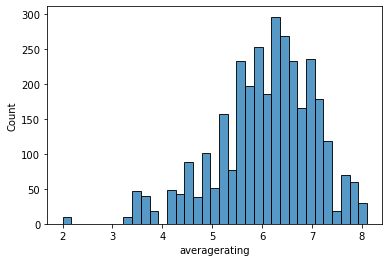

In [59]:
# Explore Likely Target
# Despite some outlier values the target seems to be normally distributed.
# Leaving it for now, I'd like to check later to see if removing this data, or modifying it's upstream processing, will have meaningful impact on model performance.
sns.histplot(data.averagerating)

<AxesSubplot:xlabel='averagerating', ylabel='Density'>

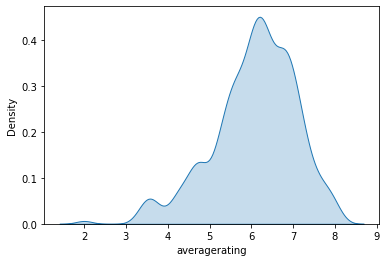

In [60]:
# further exploring the outlier impact.
sns.kdeplot(data.averagerating, shade=True)

<AxesSubplot:xlabel='runtimeminutes', ylabel='Count'>

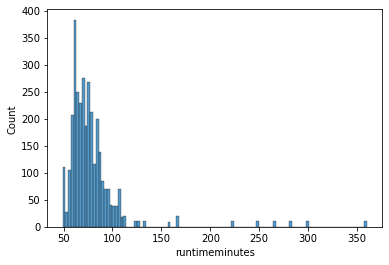

In [61]:
# Explore Interesting Independent Variables
# Let's take a look at those runtimes
sns.histplot(data.runtimeminutes)
# Upn visual inspection it looks like most of our data has a runtime less than 125 minutes.

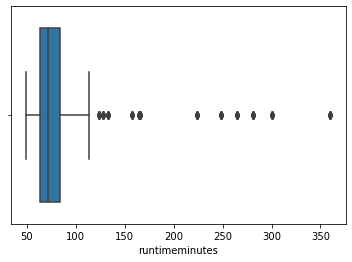

In [62]:
# Let's use a boxplot to explore this distribution further using quartiles.
sns.boxplot(data=data, x='runtimeminutes')
plt.show()


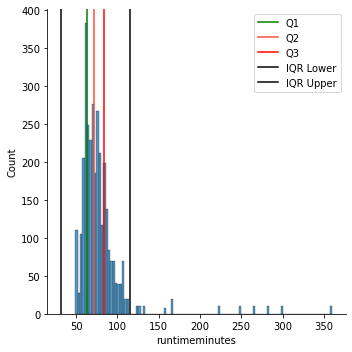

In [63]:
# Using Numpy I'll first calculate the IQR, then use it to identify and remove outliers found in the runtimeminute variable.
q1 = np.quantile(data.runtimeminutes, 0.25)
q2 = np.quantile(data.runtimeminutes, 0.5)
q3 = np.quantile(data.runtimeminutes, 0.75)

# calc iqr
iqr = (q3 - q1)
# expand iqr to discern outliers
iqr_x = iqr*1.5

# setting the lower and upper limits
iqr_lower = q1-iqr_x
iqr_upper = q3+iqr_x


sns.displot(data.runtimeminutes)
plt.axvline(x=q1, label="Q1", c = 'g')
plt.axvline(x=q2, label="Q2", c = '#fd4d3f')
plt.axvline(x=q3, label="Q3", c = 'r')

plt.axvline(x=iqr_lower, label = 'IQR Lower', c = 'black')
plt.axvline(x=iqr_upper, label = 'IQR Upper', c = 'black')
plt.legend()
plt.show()

In [64]:
# trimming off everything above and below the threshold.
data2 = data[data.runtimeminutes > iqr_lower]
data = data2[data2.runtimeminutes < iqr_upper]

In [65]:
data.shape
# we've lost only a small number of rows.
#TODO get the original number and show difference.

(3155, 15)

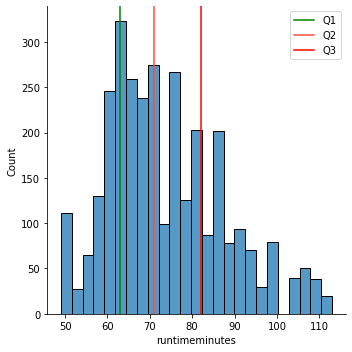

In [66]:
# checking out the new distribution
q1 = np.quantile(data.runtimeminutes, 0.25)
q2 = np.quantile(data.runtimeminutes, 0.5)
q3 = np.quantile(data.runtimeminutes, 0.75)

sns.displot(data.runtimeminutes)
plt.axvline(x=q1, label="Q1", c = 'g')
plt.axvline(x=q2, label="Q2", c = '#fd4d3f')
plt.axvline(x=q3, label="Q3", c = 'r')

plt.legend()
plt.show()

<AxesSubplot:xlabel='runtimeminutes', ylabel='Density'>

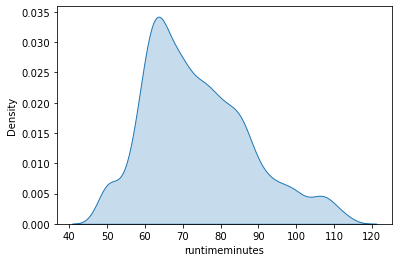

In [67]:
sns.kdeplot(data.runtimeminutes, shade=True, label='data')

In [72]:
# checking out these new summary stats
# the max is a more realistic two hours or so while the mean remains about the same. The standard deviation has also been halved.
data.runtimeminutes.describe(include = 'all')

count    3155.000000
mean       73.774960
std        13.776136
min        49.000000
25%        63.000000
50%        71.000000
75%        82.000000
max       113.000000
Name: runtimeminutes, dtype: float64

In [74]:
# looking at another interesting variable
data.numvotes.describe(include = 'all')

count     3155.000000
mean      3602.506498
std      10522.922361
min          6.000000
25%        118.000000
50%        593.000000
75%       2523.000000
max      94860.000000
Name: numvotes, dtype: float64

<AxesSubplot:xlabel='numvotes', ylabel='Count'>

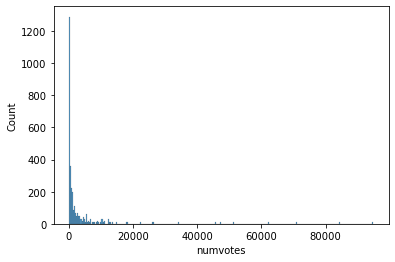

In [76]:
sns.histplot(data,x='numvotes')
# wow, 

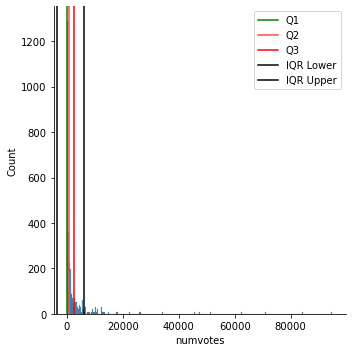

In [79]:
q1 = np.quantile(data.numvotes, 0.25)
q2 = np.quantile(data.numvotes, 0.5)
q3 = np.quantile(data.numvotes, 0.75)

# calc iqr
iqr = (q3 - q1)
# expand iqr to discern outliers
iqr_x = iqr*1.5

# setting the lower and upper limits
iqr_lower = q1-iqr_x
iqr_upper = q3+iqr_x


sns.displot(data.numvotes)
plt.axvline(x=q1, label="Q1", c = 'g')
plt.axvline(x=q2, label="Q2", c = '#fd4d3f')
plt.axvline(x=q3, label="Q3", c = 'r')

plt.axvline(x=iqr_lower, label = 'IQR Lower', c = 'black')
plt.axvline(x=iqr_upper, label = 'IQR Upper', c = 'black')
plt.legend()
plt.show()

In [80]:
# trimming off everything above and below the threshold.
data2 = data[data.numvotes > iqr_lower]
data = data2[data2.numvotes < iqr_upper]

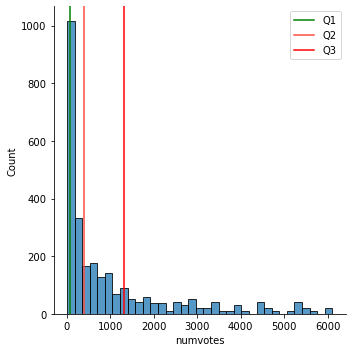

In [82]:
q1 = np.quantile(data.numvotes, 0.25)
q2 = np.quantile(data.numvotes, 0.5)
q3 = np.quantile(data.numvotes, 0.75)



sns.displot(data.numvotes)
plt.axvline(x=q1, label="Q1", c = 'g')
plt.axvline(x=q2, label="Q2", c = '#fd4d3f')
plt.axvline(x=q3, label="Q3", c = 'r')


plt.legend()
plt.show()

In [84]:
data.numvotes.describe(include = 'all')

count    2777.000000
mean     1039.512784
std      1409.249160
min         6.000000
25%        87.000000
50%       393.000000
75%      1325.000000
max      6103.000000
Name: numvotes, dtype: float64

<AxesSubplot:xlabel='numvotes', ylabel='Count'>

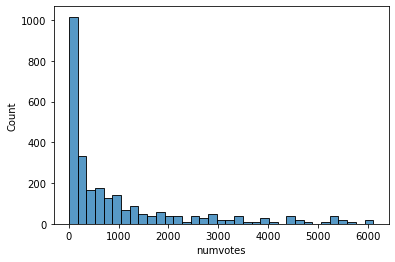

In [85]:
sns.histplot(data,x='numvotes')

In [88]:
data.numvotes.value_counts()

28.0      57
32.0      36
24.0      35
49.0      30
991.0     30
          ..
1160.0     7
167.0      7
245.0      7
85.0       6
11.0       2
Name: numvotes, Length: 248, dtype: int64

In [101]:
data[data.numvotes == 6].shape
# Although trimming off outliers 

(7, 15)

In [ ]:
### 3.1 Summary Stats: Visualization
sns.histplot(data.averagerating) 

In [ ]:
sns.histplot(data.numvotes)

In [ ]:
data.numvotes.unique()

In [ ]:
to_encode = ['tconst','nconst','primarytitle','genres','category','primaryname','primaryprofession','knownfortitles','directors','writers']
#to_encode = ['genres']

In [ ]:
to_encode

In [ ]:
## Visualization: Summary Statistics
## Preprocess Data
from sklearn.compose import ColumnTransformer,make_column_transformer

In [ ]:
Label_enc = LabelEncoder()
for i in to_encode:
    data[i]=Label_enc.fit_transform(data[i])
data

In [ ]:
data.describe()

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
standardized_data = scaler.fit_transform(data)

In [ ]:
x = pd.DataFrame(standardized_data, columns = data.columns)
x

In [ ]:
y = data['averagerating']

In [ ]:
# #Fit/Train Model
k = 3
model = KMeans(init='k-means++', n_clusters=k)

In [ ]:
model.fit_transform(standardized_data)
# Evaluate Model
model.inertia_

In [ ]:
clusters = model.predict(standardized_data).tolist()

In [ ]:
data["Cluster"] = clusters
data.Cluster.value_counts()

In [ ]:


labels = model.labels_

# check how many of the samples were correctly labeled
correct_labels = sum(y == labels)

print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))



In [ ]:
cs = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(standardized_data)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

In [ ]:
import seaborn as sns
data.columns

In [ ]:
sns.relplot(
    x="category", y="averagerating", hue="Cluster", data=data, height=6,
);

In [ ]:
# Visualization: Communicating Findings


In [ ]:
#TODO look at uniques again
